# PV Live API

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
from datetime import datetime
from pvlive_api import PVLive

## 1.0 Extracting Data from PVLive API and NESO

##### 1.1 PVLive Deployment Function - getting the Cumulative Capacity (MWp) of the GSPs

In [2]:
# Initiating PVLive API as per GiT repo instructions: https://github.com/SheffieldSolar/PV_Live-API
from pvlive_api import PVLive

pvl = PVLive(
    retries=3, # Optionally set the number of retries when intermittent issues are encountered
    proxies=None, # Optionally pass a dict of proxies to use when making requests
    ssl_verify=True, # Optionally disable SSL certificate verification (not advised!)
    domain_url="api.pvlive.uk", # Optionally switch between the prod and FOF APIs
)

In [3]:
# Getting capacity history for all GSPs (note: column is 'GSPs' = GSP name)
mwp_df = pvl.deployment(region="gsp", include_history=True) # include history given the growth of capacity over time will affect generation predictions
mwp_df

release    GSPs install_month  dc_capacity_mwp  system_count  \
0       20251024    NETS    1995-09-01              0.0             0   
1       20251024    NETS    1995-10-01              0.0             0   
2       20251024    NETS    1995-11-01              0.0             0   
3       20251024    NETS    1995-12-01              0.0             0   
4       20251024    NETS    1996-01-01              0.0             0   
...          ...     ...           ...              ...           ...   
126695  20251024  unkown    2025-06-01              0.0             0   
126696  20251024  unkown    2025-07-01              0.0             0   
126697  20251024  unkown    2025-08-01              0.0             0   
126698  20251024  unkown    2025-09-01              0.0             0   
126699  20251024  unkown    2025-10-01              0.0             0   

        sm_count  cumul_capacity_mwp  
0              0                 0.0  
1              0                 0.0  
2              0                 0.0  
3              0                 0.0  
4              0                 0.0  
...          ...                 ...  
126695         0                 0.0  
126696         0                 0.0  
126697         0                 0.0  
126698         0                 0.0  
126699         0                 0.0  

[126700 rows x 7 columns]

##### Capacity list notes

* **GSPs** is the only GSP key for linking to other dfs
* install month is the only date time identifier

##### 1.1 Getting GSP locations from NESO

In [4]:
 # GSP list downloaded from https://www.neso.energy/data-portal/gis-boundaries-gb-grid-supply-points
gsp_df = pd.read_csv("gsp_info.csv") 
print(gsp_df.shape)
print(gsp_df.head())

(380, 19)
   ng_id  ggd_id  gnode_id gnode_name  gnode_lat  gnode_lon  gsp_id gsp_name  \
0      1       1       1.0       COWL   51.71105   -1.18901     1.0   COWL_1   
1      2       2       2.0       ECLA   51.92579   -0.90565     2.0   ECLA_1   
2      3       3       3.0     ENDEDW   52.59726   -1.21548     3.0   ENDE_1   
3      4       4       4.0     GRENDW   52.24269   -0.72736     4.0   GREN_1   
4      5       5       5.0       RATS   52.86342   -1.25444     5.0   RATS_1   

    gsp_lat  gsp_lon  dc_id dc_name  dc_lat  dc_lon  region_id   region_name  \
0  51.71105 -1.18901    NaN     NaN     NaN     NaN        1.0        Cowley   
1  51.92579 -0.90565    NaN     NaN     NaN     NaN       19.0  East Claydon   
2  52.59726 -1.21548    NaN     NaN     NaN     NaN       20.0       Enderby   
3  52.24269 -0.72736    NaN     NaN     NaN     NaN       21.0       Grendon   
4  52.86342 -1.25444    NaN     NaN     NaN     NaN       22.0     Ratcliffe   

   has_pv  pes_id pes_name  

##### NESO GSP data notes:

* **gsp_name** appears to be the key to map to **GSPs** key from capacity list API - let's check that
* Other useful data include **gsp_lat**, **gsp_lon** and **region_name** - to include in merged df

##### 1.2 Checking GSPs (capacity) vs. gsp_name (NESO locations)

In [5]:
# list of unique GSPs from PVLive API
capacity_unique = mwp_df['GSPs'].dropna().unique()
print("capacity list unique count:", len(capacity_unique))
print(capacity_unique)

capacity list unique count: 334
['NETS' 'CHAP' 'BISW_1' 'PORD' 'BROR_P' 'NAIR_P' 'BRIM_1' 'ECLA_H' 'CUMB'
 'GRIW_1' 'STOR_P' 'WATFS_1' 'WBUR_1' 'CHAR_P' 'WHHO' 'AXMI1' 'LITT_J'
 'FINN' 'ELST_1' 'AYRR' 'MAYB' 'AXMI_H' 'FIDD_P' 'SFEG_P' 'ENDE_1'
 'LALE1SG003' 'PYLE_1' 'SALH_1' 'GORG' 'PERS_P' 'BIRK_1' 'LEVE' 'DRAX_1'
 'CAPEA1' 'RUGEB1' 'HELE' 'ABHA1' 'IVER_1|IVER_6' 'CUPA' 'TEMP_3' 'STLE'
 'WALP_1' 'IROA1' 'Off_NETS(unassigned)' 'DUNO_P' 'TAYN_P' 'FROD_1' 'LING'
 'QUOI_P' 'WISD_6' 'SBAR' 'GIFF' 'BOAG_P' 'BERW' 'LACK_6' 'STES_1'
 'BROA_P' 'SANX' 'WALP_B' 'NHYD_6' 'MITY_1' 'BRAC_P' 'SPAV' 'FWIL_P'
 'BARKW3' 'PADIB1' 'WARL_1' 'ELDE' 'ALVE1' 'NEEP_3' 'HURS_1' 'TELR' 'INKE'
 'MILH_1' 'FOUR_1' 'WALH_1' 'PEHS_P' 'BUSH_1' 'WILL_1' 'ECLA_1' 'WBOL_6'
 'LAIR_P' 'TARL_P' 'KEMS_1' 'SHEC_3' 'IMPK_1' 'NEAR' 'CHIC_1' 'NORT_1'
 'GLRO' 'NURS_1' 'CITR_1' 'BLYTH132' 'INDQ1' 'CONQA1|SASA' 'SJOW_1'
 'LOVE_1' 'RANN_P' 'OLDB_1' 'WTHU31' 'MELK_1' 'HAMHC1' 'DUDH_P|GLAG_P'
 'DEWP' 'SHRU' 'TOTT_1' 'HUTT_1' 'EXET1' 

In [6]:
# list of unique GSPs from PVLive API
neso_unique = gsp_df['gsp_name'].dropna().unique()
print("NESO GSP locations unique count:", len(neso_unique))
print(neso_unique)

NESO GSP locations unique count: 338
['COWL_1' 'ECLA_1' 'ENDE_1' 'GREN_1' 'RATS_1' 'STAY_1' 'SBAR' 'WBUR_1'
 'BRWA1' 'MITY_1' 'TAUN1' 'CAMB_01' 'DRAX_1' 'GRIW_1' 'KEAD_1' 'OSBA_1'
 'BARKC1' 'BARKW3' 'BEDDT1' 'BEDD_1' 'BRIM_1' 'CITR_1' 'EALI_6' 'HACK_1'
 'HACK_6' 'HURS_1' 'NFLE' 'REBR_3' 'SJOW_1' 'TOTT_1' 'WHAM_1' 'WISD_1'
 'WIMBS1' 'WIMBN1' 'BIRK_1' 'FIDF_1' 'KIBY_1' 'KIBY_G' 'LISD_1' 'PENW_1'
 'PENE_1' 'RAIN_1' 'WASF_1' 'CHIC_1' 'FOUR_1' 'FROD_1' 'IMPK_1' 'MAGA_6'
 'PYLE_1' 'SALH_1' 'TEMP_3' 'TRAW_1' 'TYNE_2' 'BICF_1' 'BRAI_1' 'BURM_1'
 'EASO_1' 'IVER_1' 'IVER_6' 'KINO_1' 'LALE1SG003' 'LODR_6' 'MILH_1'
 'NHYD_6' 'PELH_1' 'RAYL_1' 'RYEH_1' 'SUND_1' 'WARL_1' 'WATFS_1' 'WTHU31'
 'WWEY_1' 'WYMOM_1' 'BRED_1' 'KEAR_1' 'KEAR_3' 'MACC_3' 'SMAN_1' 'STAL_1'
 'WHGA_1' 'BLYTB1' 'HARM_6' 'HAWP_6' 'LACK_6' 'NORT_1' 'OFFE_3' 'SSHI_3'
 'SPEN_1' 'TYNE_1' 'WBOL_6' 'HUTT_1' 'PADIB1' 'ROCH_1' 'CELL_1' 'LEGA_1'
 'PENT_1' 'BOLN_1' 'BOTW_1' 'FAWL_1' 'FLEE_1' 'LOVE_1' 'NINF_1' 'NURS_1'
 'ABTH_1' 'CARE_1' 'IR

##### Comparison Notes:

* There are a total of 338 unique GSPs in the NESO location dataframe
* There are a total of 334 unique GSPs in the PVLive capacity data
* **Let's check the matching GSPs between dfs**

In [7]:
# normalize and strip inputs from both dfs
def norm(vals):
    s = pd.Series(vals).dropna().astype(str).str.strip().str.upper()
    return set(s.unique())

cap_set = norm(capacity_unique)
neso_set = norm(neso_unique)

intersection = cap_set & neso_set
only_in_cap = cap_set - neso_set
only_in_neso = neso_set - cap_set

print("only in capacity:", len(only_in_cap), "only in neso:", len(only_in_neso), "intersection:", len(intersection))


only in capacity: 35 only in neso: 39 intersection: 299


##### Comparison Notes:
* There are 299 matching GSP keys
* 35 appear in capacity which aren't in NESO location data
* 39 appear in NESO which aren't in MWp PVLive data
* **Let's check the 39 and 34 for errors and potential matching**

In [8]:
# sort both arrays for viewing alongside each other
cap_list = sorted(list(only_in_cap))
neso_list = sorted(list(only_in_neso))

# make DataFrame aligning by index, missing values become NaN
diff_df = pd.DataFrame({
    'only_in_capacity': pd.Series(cap_list),
    'only_in_neso': pd.Series(neso_list)
})

print(diff_df)

                      only_in_capacity only_in_neso
0   ACTL_2|CBNK_H|GREE_H|PERI_H|WESA_H       ACTL_2
1                        ALST_3|USKM_1       ALST_3
2                        ARDK_P|CLAC_P       ARDK_P
3                        ARMO_P|HARG_P       ARMO_P
4                               AXMI_H       BARKC1
5                              BARKR_A       BEAU_P
6                              BARKR_C       BRFO_1
7                        BEAU_P|ORRI_P       BRLE_1
8   BERB_P|CAIF_P|DALL_P|GLEF_P|KEIT_P       CBNK_H
9                         BRFO_1|CLT03       CLAC_P
10                       BRLE_1|FLEE_1       CONQA1
11           CAFA|EAST|GLLE|KEOO|TONG1       DUDH_P
12                         CONQA1|SASA         DUNF
13                       DUDH_P|GLAG_P       FERRB1
14                           DUNF|TOWH       FLEE_1
15                              ECLA_H       GLAG_P
16                             FERRB_M       GREE_H
17                 FETT_P|KINT_P|ROTI3       HARK_1
18          

##### Non_matching data notes:

* There appears to be some overlap, especially where two GSPs are merged in the capacity list instead of 1 identifier
* To fully unpack this would require getting in touch with the Sheffield Solar team
* Given the time constraints for this project we will progress with the 299 matching GSP identifiers to ensure accuracy in the data which is pulled forward to the machine learning phase
* **We will also remove the 'UNKOWN' GSP from the capacity list as this is likely missspelling of Unknown**

##### 1.3 Create function to merge the DFs, including:

* Align dtypes to strings
* Strip excess whitespaces
* Make case insensitive
* Remove the error **'unkown'**

In [9]:
def merge_gsp_location(mwp_df, gsp_df, gsp_col_mwp='GSPs', gsp_col_gsp='gsp_name'):
    """
    Return a copy of mwp_df with columns gsp_lat, gsp_lon, region_name merged from gsp_df.
    Matching is done case-insensitive and with whitespace stripped.
    """
    # Make copies to avoid mutating inputs
    mwp = mwp_df.copy()
    gsp = gsp_df.copy()

    # Normalize join keys by aligning to string, stripping and putting in upper case
    mwp['_gsp_key'] = mwp[gsp_col_mwp].astype(str).str.strip().str.upper()
    gsp['_gsp_key'] = gsp[gsp_col_gsp].astype(str).str.strip().str.upper()

    # Select only the columns we want to bring across (plus join key)
    to_merge = gsp[['_gsp_key', 'gsp_lat', 'gsp_lon', 'region_name']].drop_duplicates('_gsp_key')

    # Left merge so all mwp rows are kept
    merged = mwp.merge(to_merge, on='_gsp_key', how='left')
    
    # return the df where not equal to unkown
    merged = merged[merged[gsp_col_mwp] != 'unkown']
    
    # Drop helper key
    merged = merged.drop(columns=['_gsp_key'])

    return merged

In [10]:
merged_df = merge_gsp_location(mwp_df, gsp_df)
merged_df

release    GSPs install_month  dc_capacity_mwp  system_count  \
0       20251024    NETS    1995-09-01          0.00000             0   
1       20251024    NETS    1995-10-01          0.00000             0   
2       20251024    NETS    1995-11-01          0.00000             0   
3       20251024    NETS    1995-12-01          0.00000             0   
4       20251024    NETS    1996-01-01          0.00000             0   
...          ...     ...           ...              ...           ...   
126333  20251024  HAWP_6    2025-06-01          0.20912            76   
126334  20251024  HAWP_6    2025-07-01          0.16223            49   
126335  20251024  HAWP_6    2025-08-01          0.41472           155   
126336  20251024  HAWP_6    2025-09-01          0.45399           165   
126337  20251024  HAWP_6    2025-10-01          0.00000             0   

        sm_count  cumul_capacity_mwp    gsp_lat   gsp_lon     region_name  
0              0            0.000000  54.948421 -4.491001  Newton Stewart  
1              0            0.000000  54.948421 -4.491001  Newton Stewart  
2              0            0.000000  54.948421 -4.491001  Newton Stewart  
3              0            0.000000  54.948421 -4.491001  Newton Stewart  
4              0            0.000000  54.948421 -4.491001  Newton Stewart  
...          ...                 ...        ...       ...             ...  
126333         0           25.669796  54.805250 -1.401470    Hawthorn Pit  
126334         0           25.832026  54.805250 -1.401470    Hawthorn Pit  
126335         0           26.246746  54.805250 -1.401470    Hawthorn Pit  
126336         0           26.700736  54.805250 -1.401470    Hawthorn Pit  
126337         0           26.700736  54.805250 -1.401470    Hawthorn Pit  

[126338 rows x 10 columns]

In [11]:
print("Total NaNs:")
print(merged_df.isna().sum())

Total NaNs:
release                   0
GSPs                      0
install_month             0
dc_capacity_mwp           0
system_count              0
sm_count                  0
cumul_capacity_mwp        0
gsp_lat               13394
gsp_lon               13394
region_name           13394
dtype: int64


In [12]:
merged_df = merged_df.dropna(how='any').reset_index(drop=True)
merged_df

release    GSPs install_month  dc_capacity_mwp  system_count  \
0       20251024    NETS    1995-09-01          0.00000             0   
1       20251024    NETS    1995-10-01          0.00000             0   
2       20251024    NETS    1995-11-01          0.00000             0   
3       20251024    NETS    1995-12-01          0.00000             0   
4       20251024    NETS    1996-01-01          0.00000             0   
...          ...     ...           ...              ...           ...   
112939  20251024  HAWP_6    2025-06-01          0.20912            76   
112940  20251024  HAWP_6    2025-07-01          0.16223            49   
112941  20251024  HAWP_6    2025-08-01          0.41472           155   
112942  20251024  HAWP_6    2025-09-01          0.45399           165   
112943  20251024  HAWP_6    2025-10-01          0.00000             0   

        sm_count  cumul_capacity_mwp    gsp_lat   gsp_lon     region_name  
0              0            0.000000  54.948421 -4.491001  Newton Stewart  
1              0            0.000000  54.948421 -4.491001  Newton Stewart  
2              0            0.000000  54.948421 -4.491001  Newton Stewart  
3              0            0.000000  54.948421 -4.491001  Newton Stewart  
4              0            0.000000  54.948421 -4.491001  Newton Stewart  
...          ...                 ...        ...       ...             ...  
112939         0           25.669796  54.805250 -1.401470    Hawthorn Pit  
112940         0           25.832026  54.805250 -1.401470    Hawthorn Pit  
112941         0           26.246746  54.805250 -1.401470    Hawthorn Pit  
112942         0           26.700736  54.805250 -1.401470    Hawthorn Pit  
112943         0           26.700736  54.805250 -1.401470    Hawthorn Pit  

[112944 rows x 10 columns]

In [13]:
print("Total NaNs:")
print(merged_df.isna().sum())

Total NaNs:
release               0
GSPs                  0
install_month         0
dc_capacity_mwp       0
system_count          0
sm_count              0
cumul_capacity_mwp    0
gsp_lat               0
gsp_lon               0
region_name           0
dtype: int64


In [14]:
unique_gsps = merged_df['GSPs'].dropna().unique()
print("Unique GSPs:", len(unique_gsps))
print(unique_gsps)

Unique GSPs: 299
['NETS' 'CHAP' 'BISW_1' 'PORD' 'BROR_P' 'NAIR_P' 'BRIM_1' 'CUMB' 'GRIW_1'
 'WATFS_1' 'WBUR_1' 'CHAR_P' 'WHHO' 'AXMI1' 'LITT_J' 'FINN' 'ELST_1'
 'AYRR' 'MAYB' 'FIDD_P' 'SFEG_P' 'ENDE_1' 'LALE1SG003' 'PYLE_1' 'SALH_1'
 'GORG' 'PERS_P' 'BIRK_1' 'LEVE' 'DRAX_1' 'CAPEA1' 'RUGEB1' 'HELE' 'ABHA1'
 'CUPA' 'TEMP_3' 'STLE' 'WALP_1' 'IROA1' 'DUNO_P' 'TAYN_P' 'FROD_1' 'LING'
 'WISD_6' 'SBAR' 'GIFF' 'BOAG_P' 'BERW' 'LACK_6' 'STES_1' 'BROA_P' 'SANX'
 'WALP_B' 'NHYD_6' 'MITY_1' 'BRAC_P' 'SPAV' 'FWIL_P' 'BARKW3' 'PADIB1'
 'WARL_1' 'ELDE' 'ALVE1' 'NEEP_3' 'HURS_1' 'TELR' 'INKE' 'MILH_1' 'FOUR_1'
 'WALH_1' 'PEHS_P' 'BUSH_1' 'WILL_1' 'ECLA_1' 'WBOL_6' 'LAIR_P' 'TARL_P'
 'KEMS_1' 'SHEC_3' 'IMPK_1' 'NEAR' 'CHIC_1' 'NORT_1' 'GLRO' 'NURS_1'
 'CITR_1' 'BLYTH132' 'INDQ1' 'SJOW_1' 'LOVE_1' 'RANN_P' 'OLDB_1' 'WTHU31'
 'MELK_1' 'HAMHC1' 'DEWP' 'SHRU' 'TOTT_1' 'HUTT_1' 'EXET1' 'BOLN_1'
 'BESW_1' 'KILT' 'DRUM' 'STAY_1' 'JOHN' 'STEN_1' 'THOM_6' 'LITT_C'
 'MANN_1' 'CAMB_01' 'WWEY_1' 'KINO_1' 'PEHG_P'

##### Unique GSPs in Merged df notes:

* We dropped all NaN values and the unkown error
* Now there are 299 GSPs now with locational data
* This matches the 299 intersection between the NESO data and the capacity data - let's double check the intersection matches

In [15]:
# normalize helper
def norm_set(vals):
    import pandas as pd
    return set(pd.Series(list(vals)))

u_set = norm_set(unique_gsps)
i_set = norm_set(intersection)

print("equal:", u_set == i_set)

equal: True


Confirmed they are the same, now we will incorporate the drop NaN values in the merge function for later use in our .py file

In [28]:
def merge_gsp_location(mwp_df, gsp_df, gsp_col_mwp='GSPs', gsp_col_gsp='gsp_name'):
    """
    Return a copy of mwp_df with columns gsp_lat, gsp_lon, region_name merged from gsp_df.
    Matching is done case-insensitive and with whitespace stripped.
    Remove the 'unkown' rows from the mwp_df - presumably misspelling of unknown.
    Drop any rows with missing values.
    
    """
    # Make copies to avoid mutating inputs
    mwp = mwp_df.copy()
    gsp = gsp_df.copy()

    # Normalize join keys by aligning to string, stripping and putting in upper case
    mwp['_gsp_key'] = mwp[gsp_col_mwp].astype(str).str.strip().str.upper()
    gsp['_gsp_key'] = gsp[gsp_col_gsp].astype(str).str.strip().str.upper()

    # Select only the columns we want to bring across (plus join key)
    to_merge = gsp[['_gsp_key', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']].drop_duplicates('_gsp_key')

    # Left merge so all mwp rows are kept
    merged = mwp.merge(to_merge, on='_gsp_key', how='left')

    # drop all rows where ther are NaN values - return only the 299 intersection GSPs
    merged = merged.dropna(how='any')
    
    # return the df where not equal to unkown
    merged = merged[merged[gsp_col_mwp] != 'unkown']
    
    # Drop helper key
    merged = merged.drop(columns=['_gsp_key'])

    return merged

In [29]:
merged_df = merge_gsp_location(mwp_df, gsp_df)
merged_df

release    GSPs install_month  dc_capacity_mwp  system_count  \
0       20251024    NETS    1995-09-01          0.00000             0   
1       20251024    NETS    1995-10-01          0.00000             0   
2       20251024    NETS    1995-11-01          0.00000             0   
3       20251024    NETS    1995-12-01          0.00000             0   
4       20251024    NETS    1996-01-01          0.00000             0   
...          ...     ...           ...              ...           ...   
126333  20251024  HAWP_6    2025-06-01          0.20912            76   
126334  20251024  HAWP_6    2025-07-01          0.16223            49   
126335  20251024  HAWP_6    2025-08-01          0.41472           155   
126336  20251024  HAWP_6    2025-09-01          0.45399           165   
126337  20251024  HAWP_6    2025-10-01          0.00000             0   

        sm_count  cumul_capacity_mwp    gsp_lat   gsp_lon     region_name  \
0              0            0.000000  54.948421 -4.491001  Newton Stewart   
1              0            0.000000  54.948421 -4.491001  Newton Stewart   
2              0            0.000000  54.948421 -4.491001  Newton Stewart   
3              0            0.000000  54.948421 -4.491001  Newton Stewart   
4              0            0.000000  54.948421 -4.491001  Newton Stewart   
...          ...                 ...        ...       ...             ...   
126333         0           25.669796  54.805250 -1.401470    Hawthorn Pit   
126334         0           25.832026  54.805250 -1.401470    Hawthorn Pit   
126335         0           26.246746  54.805250 -1.401470    Hawthorn Pit   
126336         0           26.700736  54.805250 -1.401470    Hawthorn Pit   
126337         0           26.700736  54.805250 -1.401470    Hawthorn Pit   

        pes_id  
0         18.0  
1         18.0  
2         18.0  
3         18.0  
4         18.0  
...        ...  
126333    15.0  
126334    15.0  
126335    15.0  
126336    15.0  
126337    15.0  

[112944 rows x 11 columns]

In [30]:
unique_gsps = merged_df['GSPs'].dropna().unique()
print("Unique GSPs:", len(unique_gsps))
print(unique_gsps)

Unique GSPs: 299
['NETS' 'CHAP' 'BISW_1' 'PORD' 'BROR_P' 'NAIR_P' 'BRIM_1' 'CUMB' 'GRIW_1'
 'WATFS_1' 'WBUR_1' 'CHAR_P' 'WHHO' 'AXMI1' 'LITT_J' 'FINN' 'ELST_1'
 'AYRR' 'MAYB' 'FIDD_P' 'SFEG_P' 'ENDE_1' 'LALE1SG003' 'PYLE_1' 'SALH_1'
 'GORG' 'PERS_P' 'BIRK_1' 'LEVE' 'DRAX_1' 'CAPEA1' 'RUGEB1' 'HELE' 'ABHA1'
 'CUPA' 'TEMP_3' 'STLE' 'WALP_1' 'IROA1' 'DUNO_P' 'TAYN_P' 'FROD_1' 'LING'
 'WISD_6' 'SBAR' 'GIFF' 'BOAG_P' 'BERW' 'LACK_6' 'STES_1' 'BROA_P' 'SANX'
 'WALP_B' 'NHYD_6' 'MITY_1' 'BRAC_P' 'SPAV' 'FWIL_P' 'BARKW3' 'PADIB1'
 'WARL_1' 'ELDE' 'ALVE1' 'NEEP_3' 'HURS_1' 'TELR' 'INKE' 'MILH_1' 'FOUR_1'
 'WALH_1' 'PEHS_P' 'BUSH_1' 'WILL_1' 'ECLA_1' 'WBOL_6' 'LAIR_P' 'TARL_P'
 'KEMS_1' 'SHEC_3' 'IMPK_1' 'NEAR' 'CHIC_1' 'NORT_1' 'GLRO' 'NURS_1'
 'CITR_1' 'BLYTH132' 'INDQ1' 'SJOW_1' 'LOVE_1' 'RANN_P' 'OLDB_1' 'WTHU31'
 'MELK_1' 'HAMHC1' 'DEWP' 'SHRU' 'TOTT_1' 'HUTT_1' 'EXET1' 'BOLN_1'
 'BESW_1' 'KILT' 'DRUM' 'STAY_1' 'JOHN' 'STEN_1' 'THOM_6' 'LITT_C'
 'MANN_1' 'CAMB_01' 'WWEY_1' 'KINO_1' 'PEHG_P'

In [31]:
print("Total NaNs:")
print(merged_df.isna().sum())

Total NaNs:
release               0
GSPs                  0
install_month         0
dc_capacity_mwp       0
system_count          0
sm_count              0
cumul_capacity_mwp    0
gsp_lat               0
gsp_lon               0
region_name           0
pes_id                0
dtype: int64


##### 1.4 Check the number of unique locations in the time-series df - this should match the 299 number of unique GSPs - if not there is error in time

##### 2.0 Plotting the GSPs on a map

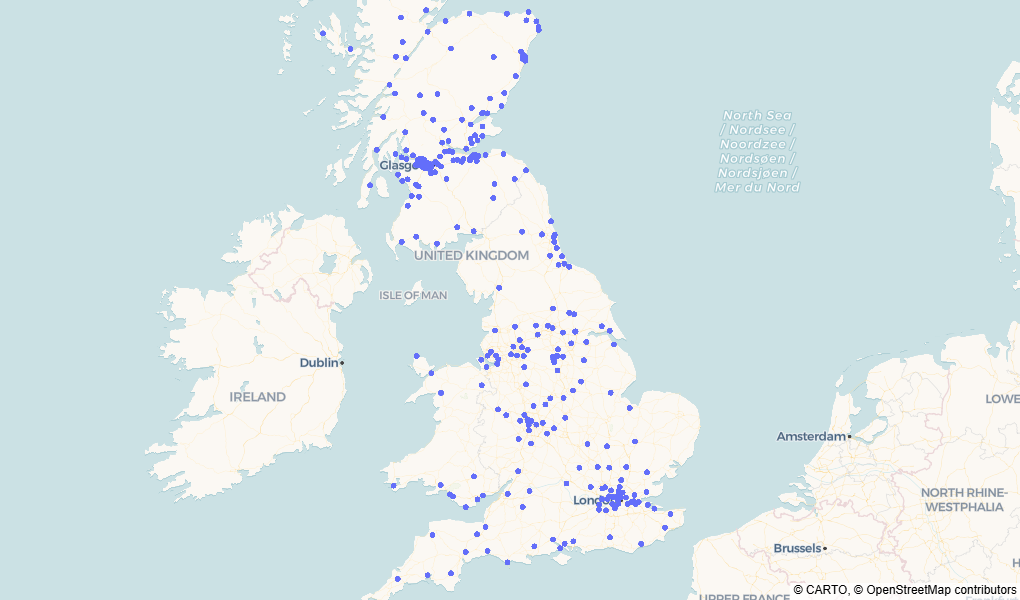

In [32]:
# Plot the GSPs on a map
fig = px.scatter_map(
    merged_df,
    lat="gsp_lat",
    lon="gsp_lon",
    hover_name="region_name",           # 'region' name
    zoom=5,
    height=600,
)

fig.update_layout(mapbox_style="open-street-map", margin=dict(l=0, r=0, t=0, b=0))
fig.show()

##### 2.1 Extract df from merged df to use a locational reference, prior to building time-series df for capacity

In [36]:
def gsp_locations(merged_df, gsp_col='GSPs'):
    """
    Return a DataFrame with one row per unique GSP from merged_df containing
    gsp_col, gsp_lat, gsp_lon, and region_name. Keeps the first occurrence per GSP.
    """
    return merged_df.drop_duplicates(subset=[gsp_col])[[gsp_col, 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']].reset_index(drop=True)

In [37]:
gsp_locations = gsp_locations(merged_df)

In [38]:
gsp_locations

GSPs    gsp_lat   gsp_lon     region_name  pes_id
0      NETS  54.948421 -4.491001  Newton Stewart    18.0
1      CHAP  55.016530 -3.229370     Chapelcross    18.0
2    BISW_1  52.311720 -2.240280    Bishops Wood    14.0
3      PORD  55.873420 -4.254200     Port Dundas    18.0
4    BROR_P  58.020320 -3.875640           Brora    17.0
..      ...        ...       ...             ...     ...
294  REBR_3  51.588030  0.044630       Redbridge    12.0
295  SHIN_P  57.943890 -4.412320            Shin    17.0
296  LEGA_1  53.028230 -3.052460          Legacy    13.0
297  KIIN_P  56.477150 -4.328190          Killin    17.0
298  HAWP_6  54.805250 -1.401470    Hawthorn Pit    15.0

[299 rows x 5 columns]

##### 2.2 Time-series df for growth of GSP capacity over time

In [24]:
def wide_cumul_capacity(merged_df, time_col='install_month', gsp_col='GSPs', value_col='cumul_capacity_mwp'):
    """
    Return a wide DataFrame with:
    - one column for the time (time_col)
    - one column per GSP (column name = GSP identifier)
    - cells = value_col (cumulative capacity MWP)
    """
    import pandas as pd
    df = merged_df.copy()
    try:
        df[time_col] = pd.to_datetime(df[time_col])
    except Exception:
        pass
    wide = df.pivot_table(index=time_col, columns=gsp_col, values=value_col, aggfunc='first')
    wide = wide.reset_index()  # make time a regular column
    return wide

In [25]:
capacity_growth_by_gsp = wide_cumul_capacity(merged_df)
capacity_growth_by_gsp

GSPs install_month       ABHA1     ABNE_P      ABTH_1    ACTL_C    ALNE_P  \
0       1995-09-01    0.000000   0.000000    0.000000  0.000000  0.000000   
1       1995-10-01    0.000000   0.000000    0.000000  0.000000  0.000000   
2       1995-11-01    0.000000   0.000000    0.000000  0.000000  0.000000   
3       1995-12-01    0.000000   0.000000    0.000000  0.000000  0.000000   
4       1996-01-01    0.000000   0.000000    0.000000  0.000000  0.000000   
..             ...         ...        ...         ...       ...       ...   
357     2025-06-01  214.240365  30.314837  108.656316  1.840502  4.904954   
358     2025-07-01  215.321815  30.433657  109.197696  1.889062  5.053374   
359     2025-08-01  216.195355  30.655497  109.598166  1.974042  5.115444   
360     2025-09-01  216.893525  30.841157  110.066366  1.997992  5.251374   
361     2025-10-01  216.893525  30.841157  110.066366  1.997992  5.251374   

GSPs       ALVE1      AMEM_1     ARBR_P       AXMI1  ...     WIMBS1    WIOW_P  \
0       0.000000    0.000000   0.000000    0.000000  ...   0.000000  0.000000   
1       0.000000    0.000000   0.000000    0.000000  ...   0.000000  0.000000   
2       0.000000    0.000000   0.000000    0.000000  ...   0.000000  0.000000   
3       0.000000    0.000000   0.000000    0.000000  ...   0.000000  0.000000   
4       0.000000    0.000000   0.000000    0.000000  ...   0.000000  0.000000   
..           ...         ...        ...         ...  ...        ...       ...   
357   426.505447  138.856232  27.414044  129.035279  ...  28.346643  1.135372   
358   427.161497  139.003572  27.561704  129.457959  ...  28.722903  1.151372   
359   427.782037  139.118002  27.605914  129.763979  ...  29.358503  1.154612   
360   470.615747  139.316032  27.775074  130.124039  ...  29.668713  1.212882   
361   470.615747  139.316032  27.775074  130.124039  ...  29.668713  1.212882   

GSPs     WISD_1    WISD_6     WMEL_1    WOHI_P    WTHU31     WWEY_1  \
0      0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
1      0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
2      0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
3      0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
4      0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
..          ...       ...        ...       ...       ...        ...   
357   10.759067  1.458922  47.195548  3.329154  2.852032  55.532479   
358   10.979377  1.501472  47.909488  3.345974  2.856032  56.060649   
359   11.146627  1.501472  48.672488  3.362024  2.883612  56.647679   
360   11.275047  1.513542  49.292698  3.422424  2.906452  57.261269   
361   11.275047  1.513542  49.292698  3.422424  2.906452  57.261269   

GSPs      WYLF_1    WYMOM_1  
0       0.000000   0.000000  
1       0.000000   0.000000  
2       0.000000   0.000000  
3       0.000000   0.000000  
4       0.000000   0.000000  
..           ...        ...  
357   122.709276  74.556895  
358   123.401716  75.319395  
359   124.034016  75.850555  
360   124.608556  76.554975  
361   124.608556  76.554975  

[362 rows x 300 columns]

C:\Users\SamF\AppData\Local\Temp\ipykernel_10132\1625317431.py:18: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



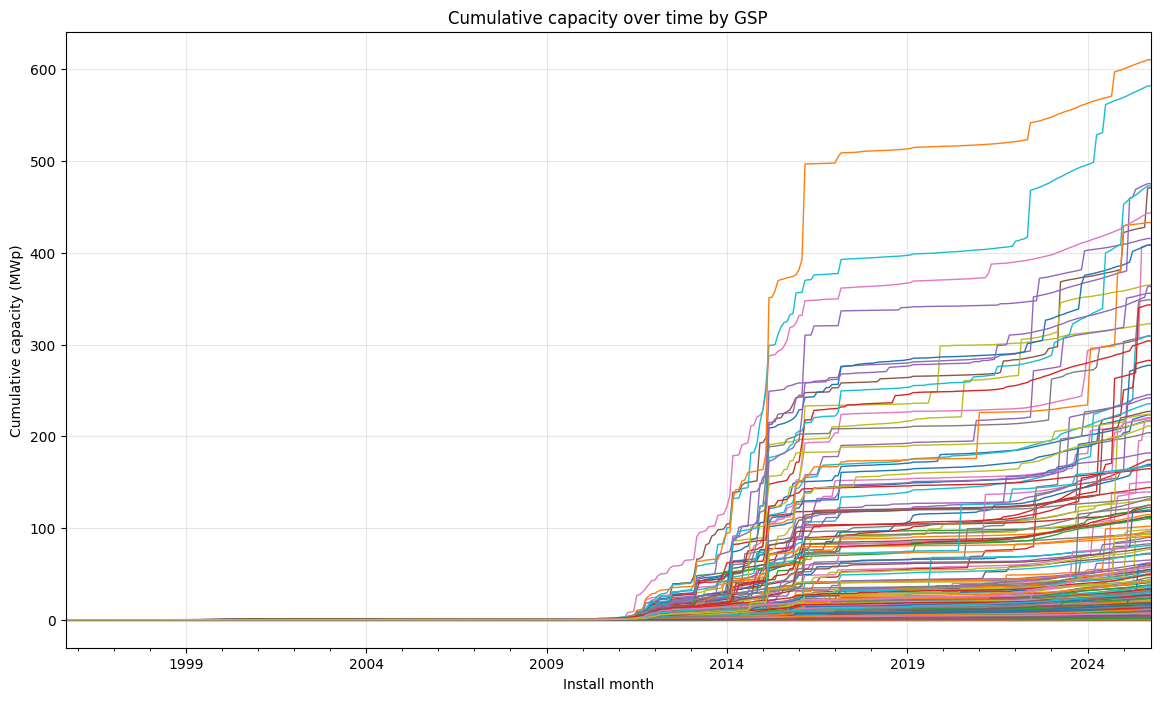

In [26]:
def plot_cumul_capacity(capacity_growth_by_gsp, time_col='install_month', figsize=(14,8), lw=1):
    """
    Plot cumulative capacity time series for each GSP column in capacity_growth_by_gsp.
    Assumes one column is the time_col and all other columns are GSP identifiers containing numeric values of cumulative capacity.
    Legend is removed.
    """
    df = capacity_growth_by_gsp.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.set_index(time_col).sort_index()

    gsp_cols = [c for c in df.columns if c != time_col]
    plt.figure(figsize=figsize)
    df[gsp_cols].plot(ax=plt.gca(), linewidth=lw)
    plt.xlabel('Install month')
    plt.ylabel('Cumulative capacity (MWp)')
    plt.title('Cumulative capacity over time by GSP')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    # remove legend
    plt.gca().legend_.remove() if plt.gca().legend_ else None
    plt.show()
plot_cumul_capacity(capacity_growth_by_gsp)

##### The Above graph shows the increasing solar capacity (MW) of each GSP over time, this is important because:

* The variable capacity will have a direct impact on the generation potential
* It is essential we capture the time-series element of capacity growth when training and testing ML models and targeting the generation output  
* We can incorporate this with the weather data over given periods to predict outputs, but:
* **Note: Weather data will typically come in 2, 15 or 30 minute periods and this data is shown in monthly periods so we will need to align dates**